In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#--export--#
from exports.e_02_MNISTLoader import loadMNIST
from exports.e_04_DataAPI import Dataset
from exports.e_05_Losses_Optimizers_TrainEval import make_dls
from exports.e_06_Callbacks import *

import math
from matplotlib import pyplot as plt
from functools import partial

In [3]:
x_train, y_train, x_valid, y_valid = loadMNIST()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

n_sampl, n_inp = x_train.shape
n_out = 10
n_hid = 50

batch_size = 512

data_w = DataWrapper(*make_dls(train_ds, valid_ds, batch_size), n_out)
model_w = ModelWrapper(*SimpleModel(data_w), F.cross_entropy, data_w)

# Parameter Annealing
## Record and Schedule Parameters

In [4]:
#--export--#
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []
    
    def after_batch(self):
        if not self.training: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, param, sched_func):
        self.param, self.sched_f = param, sched_func
    
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.param] = self.sched_f(self.epoch/self.epochs)
    
    def begin_batch(self):
        if self.training: self.set_param()

## Annealer as a Python Wrapper

In [5]:
#--export--#
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_linear(start, end, pos): return start + pos*(end-start)

In [6]:
f = sched_linear(10, 200)
f(0.5)

105.0

In [7]:
#--export--#
@annealer
def sched_cosine(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start)/2
@annealer
def sched_static(start, end, pos): return start
@annealer
def sched_exp(start, end, pos): return start * (end/start)**pos

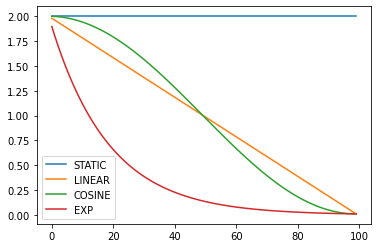

In [8]:
annealings = "STATIC LINEAR COSINE EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_static, sched_linear, sched_cosine, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend()
plt.show()

## Convenience Function to Combine Schedules

In [9]:
#--export--#
def combine_schedules(pcts, scheds):
    assert sum(pcts) == 1
    pcts = torch.tensor([0] + pcts)
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        if idx == pcts.shape[0]-1: idx -= 1
        actual_pos = (pos - pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [10]:
sched = combine_schedules([0.3, 0.7],
                          [sched_cosine(0.3, 0.6),
                           sched_cosine(0.6, 0.2)]) 

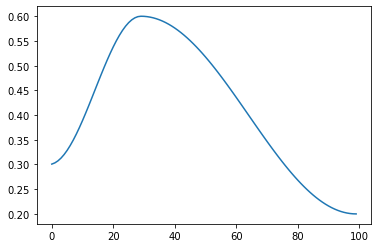

In [11]:
plt.plot(a, [sched(o) for o in p])
plt.show()

## Putting it all together: Learning Rate Annealing

In [12]:
cbs = [Recorder(),
       AvgStatsCB([acc_f]),
       ParamScheduler('lr', sched)]

job = DLJob(cbs)
job.fit(3, model_w)

train: [0.780888203125, tensor(0.7803)]
valid: [0.317395068359375, tensor(0.9056)]
train: [0.2927880078125, tensor(0.9141)]
valid: [0.24038369140625, tensor(0.9301)]
train: [0.235866171875, tensor(0.9313)]
valid: [0.2123158447265625, tensor(0.9398)]


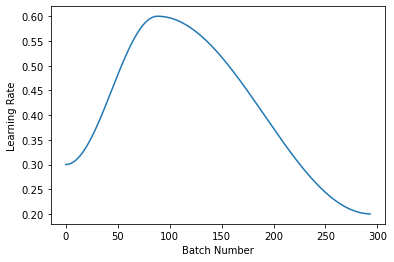

In [13]:
job.Recorder.plot_lr()
plt.xlabel('Batch Number');
plt.ylabel('Learning Rate');

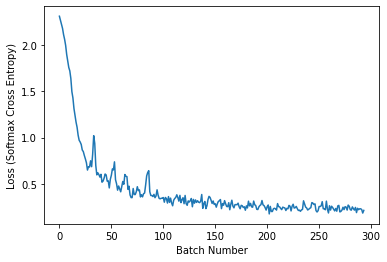

In [15]:
job.Recorder.plot_loss()
plt.xlabel('Batch Number');
plt.ylabel('Loss (Softmax Cross Entropy)');

In [16]:
!python utils/export_notebook.py 07_Annealing.ipynb

Notebook 07_Annealing.ipynb has been converted to module ./exports/e_07_Annealing.py!
